# We have create the jupyter notebook for comfort analysis and vizualization

In [29]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import seaborn as sns

In [5]:
# Load environment variables from .env file
load_dotenv()

# Retrieve environment variables
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_HOST = os.getenv("POSTGRES_HOST")
POSTGRES_PORT = os.getenv("POSTGRES_PORT")

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname=POSTGRES_DB,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    host=POSTGRES_HOST,
    port=POSTGRES_PORT
)

# Create a cursor object
cur = conn.cursor()

In [11]:
cur.execute(
    '''
    SELECT * from advanced_task
    '''
)
querry = cur.fetchall()

# Оригинальные названия столбцов
column_names = [description[0] for description in cur.description]

# Перевод в Dataframe для удобства использования
df = pd.DataFrame(querry, columns=column_names)

df.head()

,operation_timestamp,id,ad_id,type,content,created_at,ip,checked,checked_by,checked_at,checked_as,ban_id
0,2019-06-13 12:04:13,15063225,599051878,fraud,Несуществующий объект. Объявление-пустышка для...,2019-06-13 15:03:55,34,0,0,NaT,None,0
1,2019-06-13 12:04:14,15063226,599064676,fraud,Нет автомобиля в наличии! Вымогает деньги! Зан...,2019-06-13 15:03:57,0,0,0,NaT,None,0
2,2019-06-13 12:04:52,15063227,599025910,badCategory,объявление о продаже квартире в пгт Чупаховка ...,2019-06-13 15:04:23,2964,0,0,NaT,None,0
3,2019-06-13 12:04:55,15063228,599072912,fraud,Скриншоты из сайтав зделоны на деньги кинуть х...,2019-06-13 15:04:29,5,0,0,NaT,None,0
4,2019-06-13 12:04:56,15063229,599071007,fraud,Обманюють людей,2019-06-13 15:04:33,0,0,0,NaT,None,0


In [23]:
# Custom list of Russian stop words (this is a small example, you should expand this list)
russian_stop_words = [
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 
    'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 
    'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 
    'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 
    'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 
    'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 
    'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'можно', 
    'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 
    'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 
    'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'
]

In [24]:
# Fill None values in 'content' with empty strings
df['content'] = df['content'].fillna('')

# Group by complaint type and concatenate the content
grouped = df.groupby('type')['content'].apply(lambda x: ' '.join(x)).reset_index()

# Use CountVectorizer to get the most common words for each type
vectorizer = CountVectorizer(stop_words=russian_stop_words)
common_words = {}

for _, row in grouped.iterrows():
    words = vectorizer.fit_transform([row['content']])
    word_counts = pd.DataFrame(words.toarray(), columns=vectorizer.get_feature_names_out())
    common_words[row['type']] = word_counts.sum().sort_values(ascending=False).head(10)

print(common_words['fraud'])

деньги        533
товар         500
предоплату    455
мошенник      368
фото          266
это           253
людей         208
мошенники     207
цена          174
объявление    141
dtype: int64


In [26]:
# Assuming df is your DataFrame
# Fill None values in 'content' with empty strings
df['content'] = df['content'].fillna('')

# Group by complaint type and concatenate the content
grouped = df.groupby('type')['content'].apply(lambda x: ' '.join(x)).reset_index()

# Use CountVectorizer to get the most common bigrams for each type
vectorizer = CountVectorizer(stop_words=russian_stop_words, ngram_range=(3, 3))
common_bigrams = {}

for _, row in grouped.iterrows():
    words = vectorizer.fit_transform([row['content']])
    word_counts = pd.DataFrame(words.toarray(), columns=vectorizer.get_feature_names_out())
    common_bigrams[row['type']] = word_counts.sum().sort_values(ascending=False).head(10)

# Display the most common bigrams for each type
for complaint_type, bigrams in common_bigrams.items():
    print(f"Common bigrams for {complaint_type}:")
    print(bigrams)
    print("\n")

Common bigrams for agency:
рубрике частных лиц              49
агентство рубрике частных        47
частных лиц агентство            23
лиц агентство рубрике            21
предоплату получай деньги         8
деньги отключай телефон           6
получай деньги отключай           6
процентную предоплату получай     5
это агенство недвижимости         4
агенство недвижимости это         4
dtype: int64


Common bigrams for badCategory:
рубрика неверная рубрика           7
неверная рубрика неверная          6
показывается рубрике мебель        5
лафет сдается аренду               4
рубрика лафет сдается              4
неверная рубрика лафет             4
это объявление аренде              3
розділі дитячих колясок            3
удалите пожалуйста лохотронщика    3
объявление аренде квартир          3
dtype: int64


Common bigrams for fraud:
www olx ua                   72
ua list user                 66
nhttps www olx               59
olx ua list                  57
мошенник каждый день       

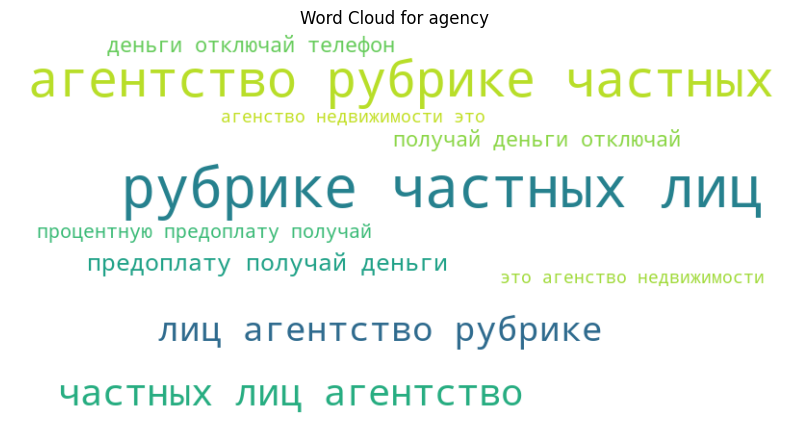

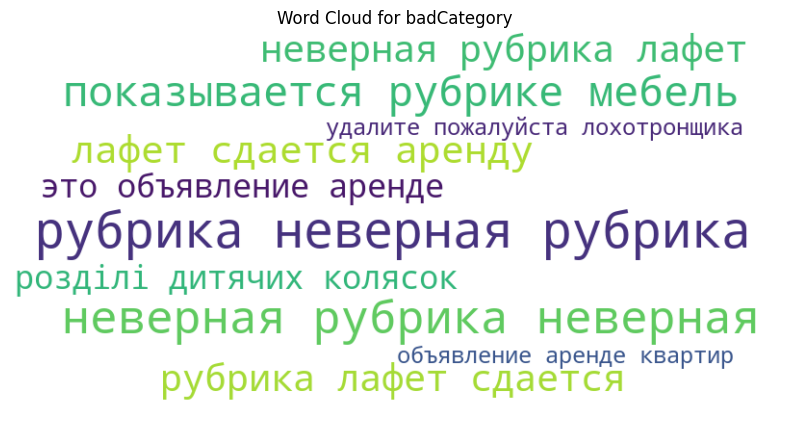

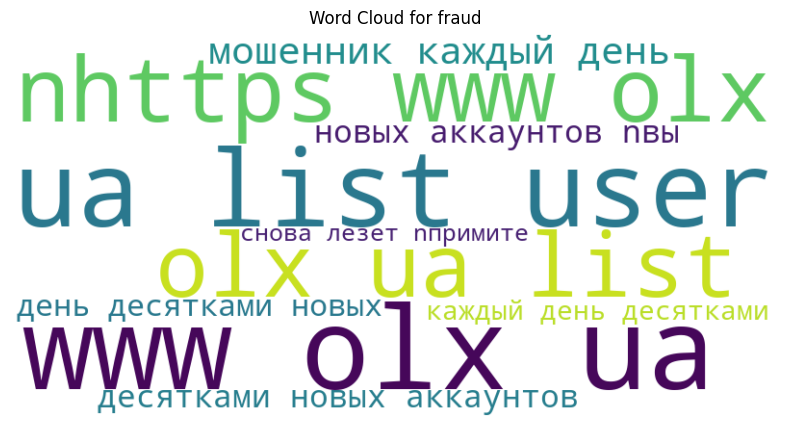

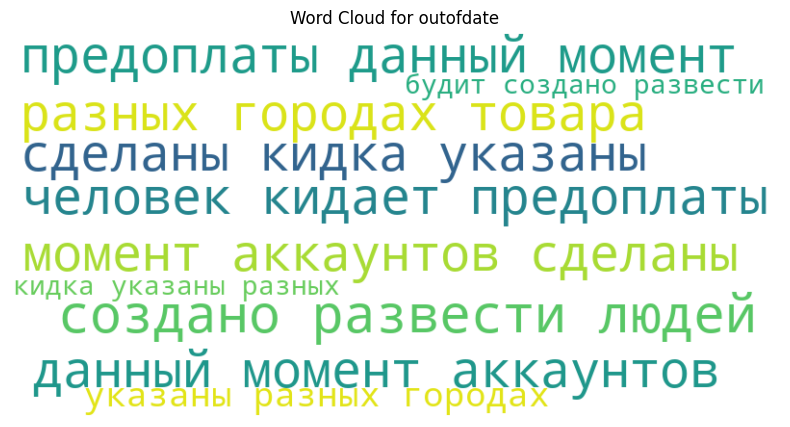

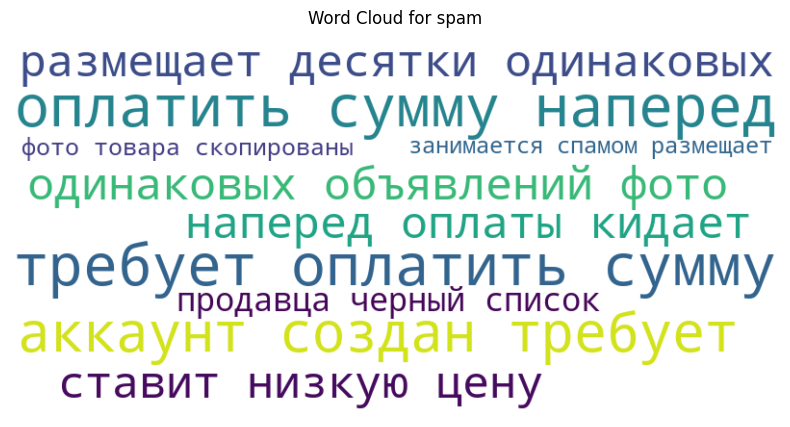

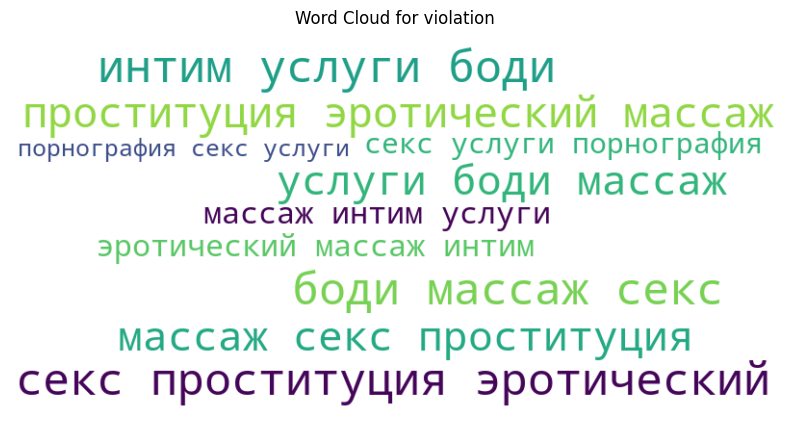

In [28]:
# Create word clouds
for complaint_type, trigrams in common_bigrams.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigrams)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {complaint_type}")
    plt.axis('off')
    plt.show()

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


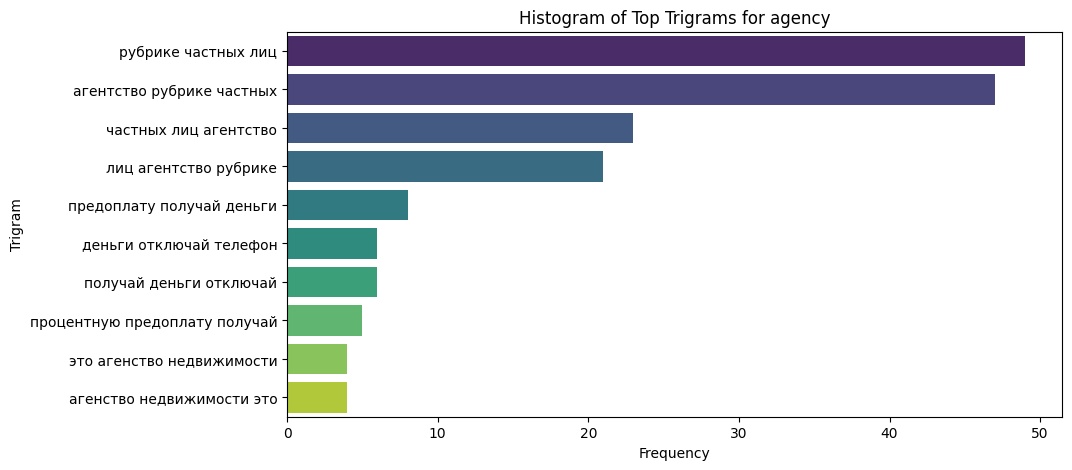

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


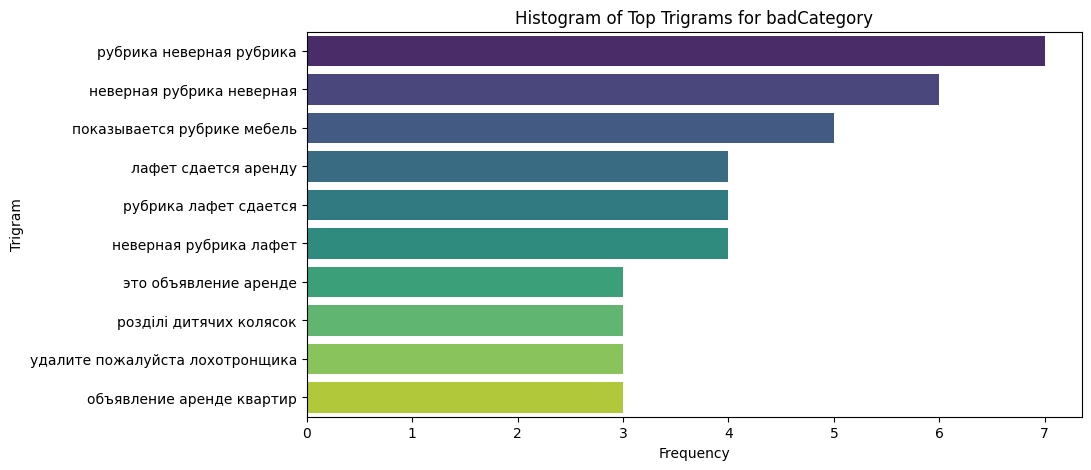

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


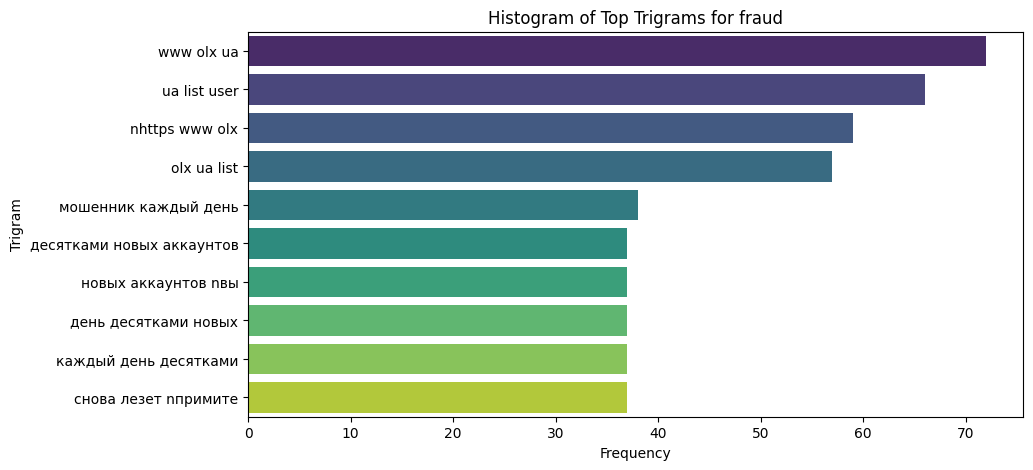

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


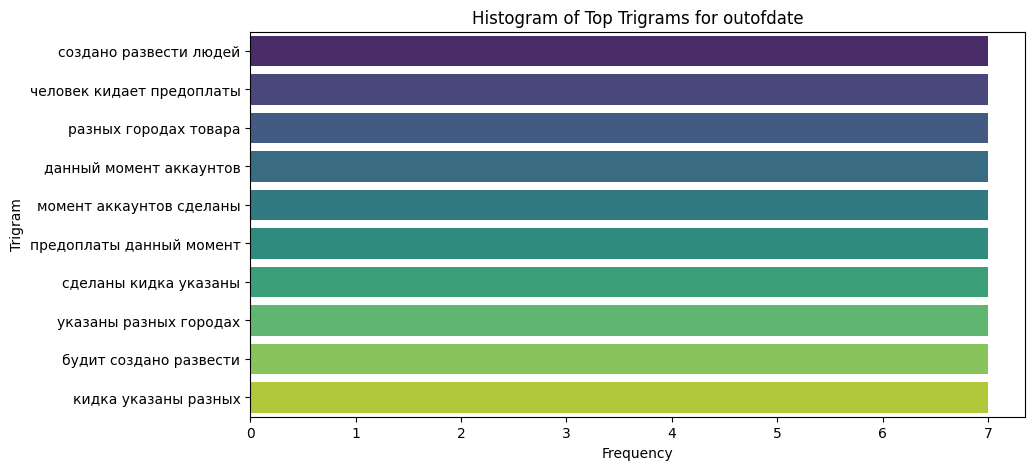

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


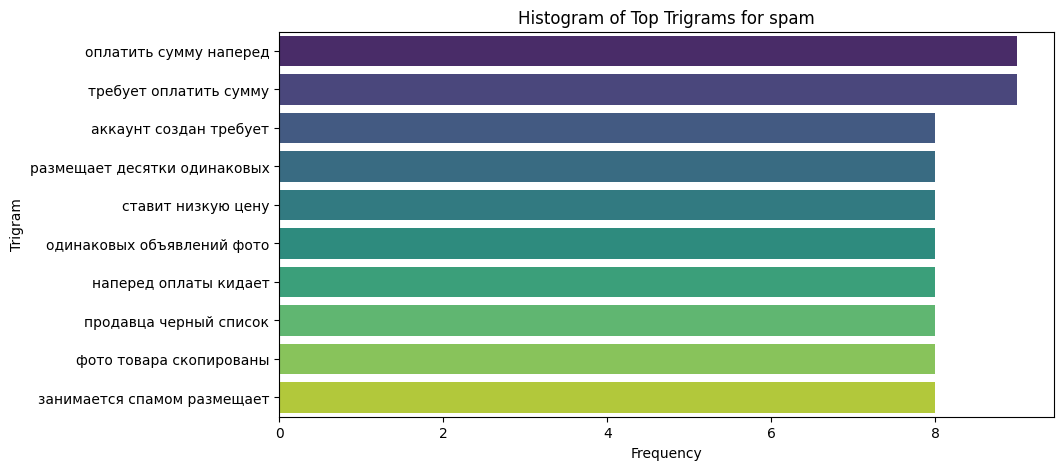

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


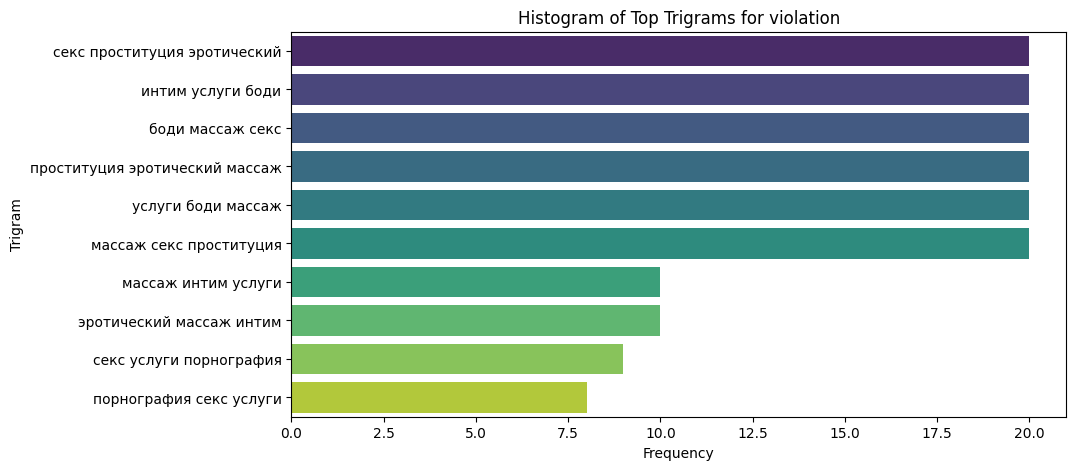

In [30]:
# Histogram
for complaint_type, trigrams in common_bigrams.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=trigrams.values, y=trigrams.index, palette='viridis')
    plt.title(f"Histogram of Top Trigrams for {complaint_type}")
    plt.xlabel('Frequency')
    plt.ylabel('Trigram')
    plt.show()

In [15]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['checked_at'] = pd.to_datetime(df['checked_at'])


df['response_time'] = df['checked_at'] - df['created_at']


reviewed_complaints = df[df['response_time'].notnull()]

# Calculate average response time
average_response_time = reviewed_complaints['response_time'].mean()
print(f'Average response time: {average_response_time}')
df.head()

Average response time: 0 days 05:39:06.797397769


,operation_timestamp,id,ad_id,type,content,created_at,ip,checked,checked_by,checked_at,checked_as,ban_id,response_time
0,2019-06-13 12:04:13,15063225,599051878,fraud,Несуществующий объект. Объявление-пустышка для...,2019-06-13 15:03:55,34,0,0,NaT,None,0,NaT
1,2019-06-13 12:04:14,15063226,599064676,fraud,Нет автомобиля в наличии! Вымогает деньги! Зан...,2019-06-13 15:03:57,0,0,0,NaT,None,0,NaT
2,2019-06-13 12:04:52,15063227,599025910,badCategory,объявление о продаже квартире в пгт Чупаховка ...,2019-06-13 15:04:23,2964,0,0,NaT,None,0,NaT
3,2019-06-13 12:04:55,15063228,599072912,fraud,Скриншоты из сайтав зделоны на деньги кинуть х...,2019-06-13 15:04:29,5,0,0,NaT,None,0,NaT
4,2019-06-13 12:04:56,15063229,599071007,fraud,Обманюють людей,2019-06-13 15:04:33,0,0,0,NaT,None,0,NaT


In [16]:
# Count the number of complaints for each type
complaint_counts = df['type'].value_counts()

print(complaint_counts)

type
fraud          3083
violation       862
outofdate       455
badCategory     230
spam            192
agency          178
Name: count, dtype: int64


          type  average_response_time  count_reviewed  total_complaints
0       agency               0.454583               7               178
1  badCategory               0.240350               8               230
2        fraud               0.235870             493              3083
3    outofdate               0.284627              13               455
4         spam               0.123026              11               192
5    violation               0.042411               6               862


c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


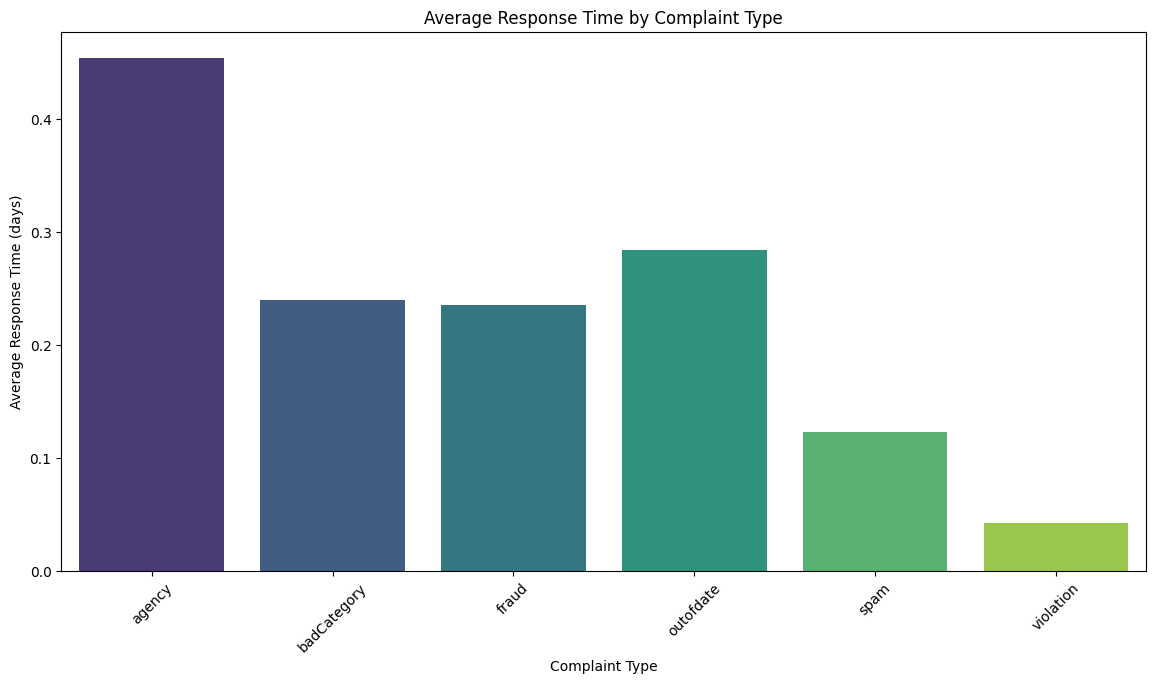

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


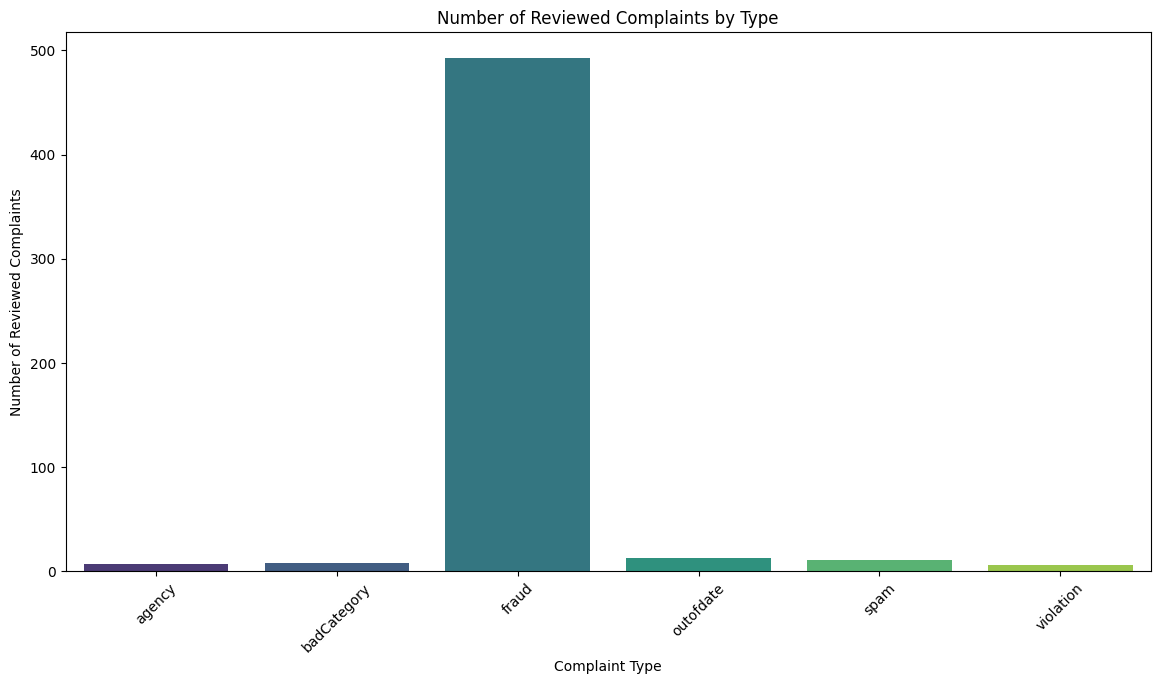

c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\k.muratbekov\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


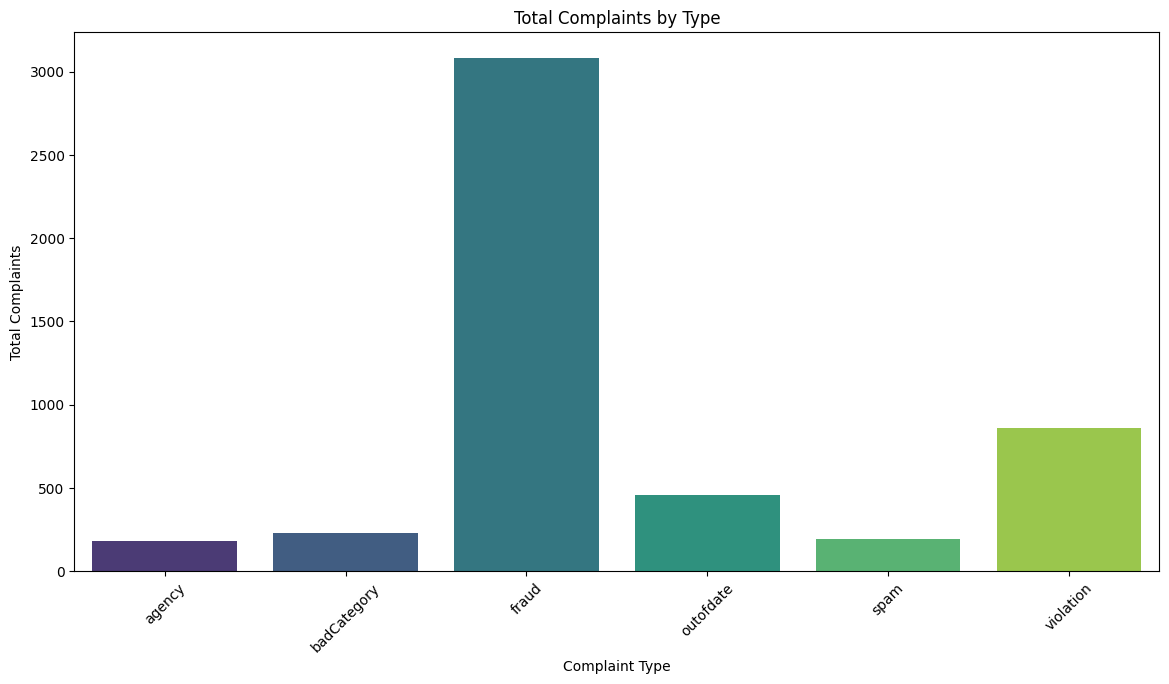

In [32]:
# Calculate response time in days
df['response_time'] = (df['checked_at'] - df['created_at']).dt.total_seconds() / (24 * 3600)


df['is_reviewed'] = df['checked_at'].notnull()


response_summary = df.groupby('type').agg(
    average_response_time=('response_time', 'mean'),
    count_reviewed=('is_reviewed', 'sum'),
    total_complaints=('id', 'count')
).reset_index()


print(response_summary)

# Plot average response time for each type
plt.figure(figsize=(14, 7))
sns.barplot(data=response_summary, x='type', y='average_response_time', palette='viridis')
plt.title('Average Response Time by Complaint Type')
plt.xlabel('Complaint Type')
plt.ylabel('Average Response Time (days)')
plt.xticks(rotation=45)
plt.show()

# Plot number of reviewed complaints for each type
plt.figure(figsize=(14, 7))
sns.barplot(data=response_summary, x='type', y='count_reviewed', palette='viridis')
plt.title('Number of Reviewed Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Reviewed Complaints')
plt.xticks(rotation=45)
plt.show()

# Plot total complaints for each type
plt.figure(figsize=(14, 7))
sns.barplot(data=response_summary, x='type', y='total_complaints', palette='viridis')
plt.title('Total Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Total Complaints')
plt.xticks(rotation=45)
plt.show()